In [4]:
import mysql.connector as sql
import pandas as pd
import datetime as dt
import numpy as np
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *
import matplotlib.pyplot as plt
import math
import json
from pandas.io.json import json_normalize
import requests
import matplotlib.dates as mdates
from datetime import date, timedelta

In [5]:
db_connection = sql.connect(host='localhost', database='collection_visits', user='pandas', password='password')

pensActivity = pd.read_sql('SELECT * FROM PensActivity', con=db_connection)
pensActivity['created'] = pd.to_datetime(pensActivity['created'], unit='s').dt.tz_localize('utc').dt.tz_convert('US/Eastern')
pensActivity['lastmodified'] = pd.to_datetime(pensActivity['lastmodified'], unit='s').dt.tz_localize('utc').dt.tz_convert('US/Eastern')
pensActivity['created'].replace(0, np.nan, inplace=True)
pensActivity['lastmodified'].replace(0, np.nan, inplace=True)
pensActivity['notes'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
pensActivity['notes'] = pensActivity['notes'].astype('category')
pensActivity.sort_values(by='created', inplace=True)

pensCheckouts = pd.read_sql('SELECT * FROM PensCheckouts', con=db_connection)
pensCheckouts['start'] = pd.to_datetime(pensCheckouts['start'], unit='s').dt.tz_localize('utc').dt.tz_convert('US/Eastern')
pensCheckouts['start'].replace(0, np.nan, inplace=True)
pensCheckouts['end'].replace(0, np.nan, inplace=True)
pensCheckouts['end'] = pd.to_datetime(pensCheckouts['end'], unit='s').dt.tz_localize('utc').dt.tz_convert('US/Eastern')
pensCheckouts['start_ip'].replace(0, np.nan, inplace=True)
pensCheckouts['end_ip'].replace(0, np.nan, inplace=True)
pensCheckouts['start_ip'] = pensCheckouts['start_ip'].astype('category')
pensCheckouts['end_ip'] = pensCheckouts['end_ip'].astype('category')
pensCheckouts.set_index('id', inplace=True)
pensCheckouts.sort_index(inplace=True)
###DROPED COLUMNS####
pensCheckouts.drop(['start_ip', 'end_ip'], axis=1, inplace=True)

In [6]:
pensCheckouts.set_index(['visit_id'], inplace=True)

In [7]:
pensActivity.set_index(['visit_id'], inplace=True)

In [8]:
checkout_activity = pensCheckouts.join(pensActivity, how='left', lsuffix='_checkout', rsuffix='_activity')

In [9]:
checkout_activity

,pen_id_checkout,start,end,pen_id_activity,fingerprint,activity,notes,status_id,created,lastmodified,time_to_process,count_items
visit_id,,,,,,,,,,,,
793401,8,2014-10-23 11:36:51-04:00,2014-10-24 20:44:42-04:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
793449,3,2014-10-23 12:25:42-04:00,2014-10-24 20:44:42-04:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
793527,9,2014-10-23 22:04:59-04:00,2014-10-24 20:44:42-04:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
793571,2,2014-10-24 11:05:23-04:00,2014-10-27 13:53:29-04:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
793681,7,2014-10-24 20:02:19-04:00,2014-10-27 13:53:29-04:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
132777683,1520099,2020-07-02 16:22:28-04:00,2020-07-02 16:22:44-04:00,1524473.0,8de20189e64f86c4f892b98ca7d30077b00b3874,"{""ticket_id"":""tzctj"",""registers"":""None"",""colle...",NaN,1.0,2020-07-02 16:22:39-04:00,2020-07-02 16:22:39-04:00,161.0,1.0
132794701,1520099,2020-07-06 13:42:18-04:00,2020-07-06 13:43:00-04:00,1524473.0,c24003e782909cd4a8385fd84970943237aa605b,"{""ticket_id"":""gz65"",""registers"":""None"",""collec...",NaN,1.0,2020-07-06 13:42:37-04:00,2020-07-06 13:42:37-04:00,159.0,1.0
132806719,1520099,2020-07-09 09:12:28-04:00,2020-07-09 09:12:46-04:00,1524473.0,513e424fc16895f97ae6e70e9bb74f9a58c59229,"{""ticket_id"":""56bs6"",""registers"":""None"",""colle...",NaN,1.0,2020-07-09 09:12:38-04:00,2020-07-09 09:12:38-04:00,172.0,1.0


In [17]:
checkout_activity_openinghours = checkout_activity.set_index('start')
checkout_activity_openinghours = checkout_activity_openinghours.between_time('10:00', '18:00')
checkout_activity_openinghours.reset_index(inplace=True)


In [18]:
checkout_activity_openinghours

,start,pen_id_checkout,end,pen_id_activity,fingerprint,activity,notes,status_id,created,lastmodified,time_to_process,count_items
0,2014-10-23 11:36:51-04:00,8,2014-10-24 20:44:42-04:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
1,2014-10-23 12:25:42-04:00,3,2014-10-24 20:44:42-04:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
2,2014-10-24 11:05:23-04:00,2,2014-10-27 13:53:29-04:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
3,2014-10-27 13:54:58-04:00,6,2014-10-28 16:49:24-04:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
4,2014-10-28 16:02:57-04:00,3,2014-11-03 13:32:08-05:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
773973,2020-07-01 14:19:22-04:00,1520099,2020-07-01 14:19:28-04:00,1524473.0,c381490efa986a976c19b9cc1514b54ae9e720b3,"{""ticket_id"":""Jtmx"",""registers"":""None"",""collec...",NaN,1.0,2020-07-01 14:22:44-04:00,2020-07-01 14:22:44-04:00,117.0,1.0
773974,2020-07-01 14:19:38-04:00,1520099,2020-07-01 14:32:22-04:00,1524473.0,c381490efa986a976c19b9cc1514b54ae9e720b3,"{""ticket_id"":""Jtmx"",""registers"":""None"",""collec...",NaN,1.0,2020-07-01 14:22:44-04:00,2020-07-01 14:22:44-04:00,117.0,1.0
773975,2020-07-02 13:18:56-04:00,1520099,2020-07-02 13:19:22-04:00,1524473.0,9f31efa2cdfad9c550201a965897f1288d7b5211,"{""ticket_id"":""ppkxy"",""registers"":""None"",""colle...",NaN,1.0,2020-07-02 13:19:11-04:00,2020-07-02 13:19:11-04:00,140.0,1.0
773976,2020-07-02 16:22:28-04:00,1520099,2020-07-02 16:22:44-04:00,1524473.0,8de20189e64f86c4f892b98ca7d30077b00b3874,"{""ticket_id"":""tzctj"",""registers"":""None"",""colle...",NaN,1.0,2020-07-02 16:22:39-04:00,2020-07-02 16:22:39-04:00,161.0,1.0


In [19]:
did_nothing = checkout_activity_openinghours[checkout_activity_openinghours['pen_id_activity'].isna()]
did_nothing

,start,pen_id_checkout,end,pen_id_activity,fingerprint,activity,notes,status_id,created,lastmodified,time_to_process,count_items
0,2014-10-23 11:36:51-04:00,8,2014-10-24 20:44:42-04:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
1,2014-10-23 12:25:42-04:00,3,2014-10-24 20:44:42-04:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
2,2014-10-24 11:05:23-04:00,2,2014-10-27 13:53:29-04:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
3,2014-10-27 13:54:58-04:00,6,2014-10-28 16:49:24-04:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
4,2014-10-28 16:02:57-04:00,3,2014-11-03 13:32:08-05:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
773926,2020-03-04 14:57:21-05:00,1522251,2020-03-04 17:13:39-05:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
773927,2020-03-04 14:57:47-05:00,1520455,2020-03-04 17:07:15-05:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
773929,2020-03-04 15:33:12-05:00,1525283,2020-03-04 17:07:29-05:00,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN
773940,2020-03-04 16:16:18-05:00,1524495,NaT,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN


In [20]:
did_nothing['pen_id_checkout'].count()

135137

In [21]:
did_nothing_yealry = did_nothing['start'].groupby(did_nothing.start.dt.to_period('Y')).agg('count')
did_nothing_yealry

/Users/shirin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


start
2014      130
2015    27959
2016    24889
2017    21525
2018    32013
2019    23180
2020     5441
Freq: A-DEC, Name: start, dtype: int64

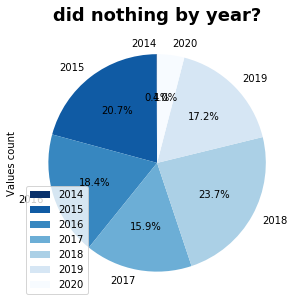

In [22]:
did_nothing_yealry.plot.pie(y='start', figsize=(5, 5),autopct='%1.1f%%', startangle=90, cmap='Blues_r')
plt.title('did nothing by year?', fontdict={'fontweight': 'bold', 'fontsize':18})
plt.ylabel('Values count')
plt.legend()

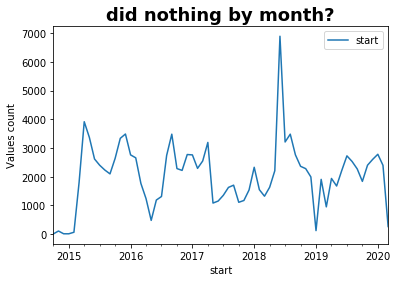

In [23]:
did_nothing_month = did_nothing['start'].groupby(did_nothing.start.dt.to_period('M')).agg('count')

did_nothing_month.plot()
plt.title('did nothing by month?', fontdict={'fontweight': 'bold', 'fontsize':18})
plt.ylabel('Values count')
plt.legend()

In [24]:
did_nothing_month.nlargest()

start
2018-06    6890
2015-04    3914
2015-12    3486
2018-08    3481
2016-09    3480
Freq: M, Name: start, dtype: int64